In [2]:
!python -V

Python 3.9.12


In [184]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.metrics import mean_squared_error

import pickle

In [185]:
def read_dataframe(filename):
    if filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    if 'lpep_pickup_datetime' in df.columns:
        df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    else:
        df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    if 'PULocationID' in df.columns:
        categorical = ['PULocationID', 'DOLocationID']
    else:
        categorical = ['PUlocationID', 'DOlocationID']
        df['PULocationID'] = 'PUlocationID'
        df['DOLocationID'] = 'DOlocationID'
        
    df[categorical] = df[categorical].fillna(-1)
    df[categorical] = df[categorical].astype(int).astype(str)

    return df

In [186]:
df_train_green = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val_green = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [187]:
df_train_fhv = read_dataframe('./data/fhv_tripdata_2021-01.parquet')
df_val_fhv = read_dataframe('./data/fhv_tripdata_2021-02.parquet')

In [188]:
dv = DictVectorizer()
def preproc(data, train=True):
    global dv
    categorical = ['PUlocationID', 'DOlocationID']
    numerical = ['trip_distance']
    features = categorical # + numerical
    dicts = data[features].to_dict(orient='records')
    if train:
        dv = DictVectorizer()        
        X = dv.fit_transform(dicts)
    else:
        X = dv.transform(dicts)

    target = 'duration'
    y = data[target].values
    return X, y


In [192]:
def train_and_eval(_X_train, _y_train, _X_val, _y_val):
    lr = LinearRegression()
    lr.fit(_X_train, _y_train)

    _y_pred = lr.predict(_X_val)
    sns.distplot(_y_pred, label='prediction')
    sns.distplot(_y_val, label='actual')
    plt.legend()
    print("mean squared error:", mean_squared_error(_y_val, _y_pred, squared=False))
    return lr

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


mean squared error: 11.014283149347039


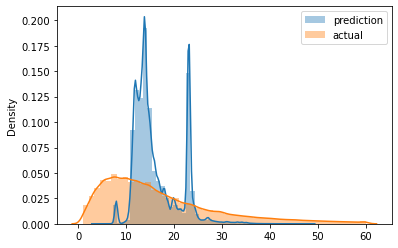

In [193]:
X_train, y_train = preproc(df_train_fhv, train=True)
X_val, y_val = preproc(df_val_fhv, train=False)
model = train_and_eval(X_train, y_train, X_val, y_val)

In [108]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, model), f_out)